In [ ]:
pip install torch torchvision Pillow

In [1]:
import numpy as np          #Berechnung von Matrizen
import random               #Generierung zufälliger Zahlen oder anderer zufälliger Operationen
import matplotlib as plt    #Erstellung von Diagrammen
import torch                #PyTorch Bibliothek 
import torch.nn as nn
import torchvision          #Verarbeitung von Bildern

In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Überprüfung, ob NN auf der GPU (Grafikkarte) ausgeführt werden kann

Trainings-CSV-Datei erstellt: bild_labels.csv
Epoch 1/3
781/781 ━━━━━━━━━━━━━━━━━━━━ 327s 407ms/step - accuracy: 0.6661 - loss: 0.6037 - val_accuracy: 0.8375 - val_loss: 0.3725
Epoch 2/3
781/781 ━━━━━━━━━━━━━━━━━━━━ 289s 370ms/step - accuracy: 0.7931 - loss: 0.4438 - val_accuracy: 0.8622 - val_loss: 0.3140
Epoch 3/3
781/781 ━━━━━━━━━━━━━━━━━━━━ 347s 444ms/step - accuracy: 0.8390 - loss: 0.3633 - val_accuracy: 0.9081 - val_loss: 0.2372


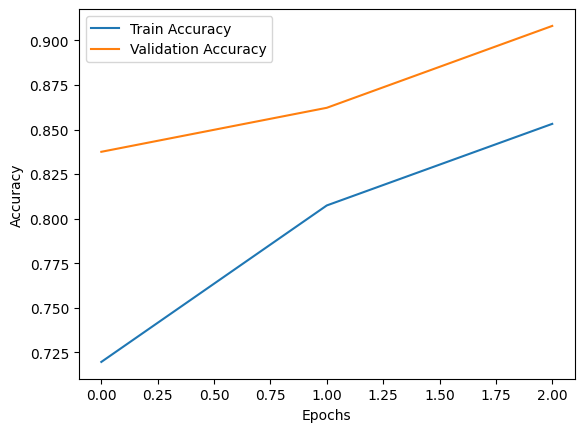

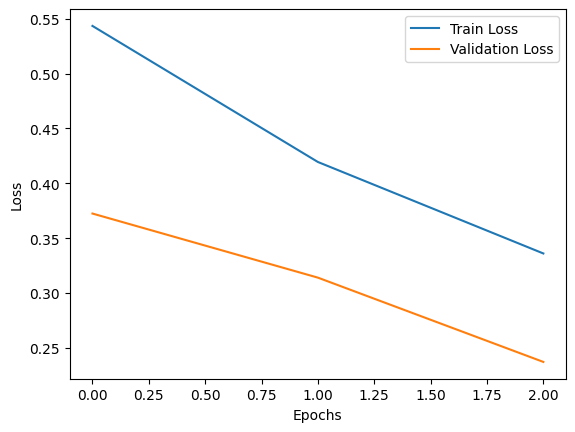

Test-CSV-Datei erstellt: test_images.csv
Fehler während der Test-Evaluierung: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 267ms/step


c:\Users\ZOSDEMIR\AppData\Local\anaconda3\envs\bigdataprojekt-2025\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Vorhersagen gespeichert in 'test_predictions.csv'.
Modell gespeichert!


In [24]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Ordnerpfade
train_dataset_path = "C:\\Users\\ZOSDEMIR\\Documents\\GitHub\\bigdataprojekt-2025\\train"
test_dataset_path = "C:\\Users\\ZOSDEMIR\\Documents\\GitHub\\bigdataprojekt-2025\\test1"

# Schritt 1: Trainings-CSV-Datei erstellen (mit korrekter Sortierung)
def create_training_csv(train_folder, output_csv_path):
    data = []
    for filename in sorted(os.listdir(train_folder), key=lambda x: int(os.path.splitext(x)[0].split(".")[1])):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = 0 if "cat" in filename.lower() else 1
            data.append({"Dateiname": filename, "Label": label})
    pd.DataFrame(data).to_csv(output_csv_path, index=False)
    print(f"Trainings-CSV-Datei erstellt: {output_csv_path}")

train_csv_path = "bild_labels.csv"
create_training_csv(train_dataset_path, train_csv_path)

# Schritt 2: Vorverarbeitung der Bilder
def preprocess_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image

# Schritt 3: TensorFlow-Datensatz erstellen
def create_dataset(dataframe, img_folder, batch_size):
    paths = [os.path.join(img_folder, fname) for fname in dataframe['Dateiname'].values]
    labels = dataframe['Label'].values.astype('int32')

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    def load_image_and_label(path, label):
        try:
            image = preprocess_image(path)
            return image, label
        except Exception as e:
            print(f"Fehler beim Laden von {path.numpy().decode('utf-8')}: {e}")
            return None, label

    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda image, label: image is not None)
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Trainingsdatensatz erstellen
batch_size = 32
df = pd.read_csv(train_csv_path)
train_dataset = create_dataset(df, train_dataset_path, batch_size)
train_dataset = train_dataset.repeat()  # Wiederhole den Datensatz

# Schritte pro Epoche berechnen
steps_per_epoch = len(df) // batch_size

# Validierungsdatensatz erstellen
val_size = 100
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

# Schritt 4: Modell definieren
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Schritt 5: Training starten
EPOCHS = 3
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch)

# Schritt 6: Trainingsergebnisse visualisieren
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Schritt 7: Test-CSV-Datei erstellen (gleiche Struktur wie Trainingsdaten, aber ohne Labels)
def create_test_csv(test_folder, output_csv_path):
    data = []
    for filename in sorted(os.listdir(test_folder), key=lambda x: int(os.path.splitext(x)[0])):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            data.append({"Dateiname": filename})
    pd.DataFrame(data).to_csv(output_csv_path, index=False)
    print(f"Test-CSV-Datei erstellt: {output_csv_path}")

test_csv_path = "test_images.csv"
create_test_csv(test_dataset_path, test_csv_path)

# Schritt 8: Testdatensatz aus der Test-CSV laden
def create_test_dataset_from_csv(csv_file, img_folder, batch_size):
    df = pd.read_csv(csv_file)
    paths = [os.path.join(img_folder, fname) for fname in df['Dateiname'].values if os.path.exists(os.path.join(img_folder, fname))]

    dataset = tf.data.Dataset.from_tensor_slices(paths)

    def load_image(path):
        try:
            image = preprocess_image(path)
            return image
        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {path.numpy().decode('utf-8')}: {e}")
            return None

    dataset = dataset.map(
        lambda path: tf.py_function(load_image, inp=[path], Tout=tf.float32),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.filter(lambda img: img is not None)

    return dataset.batch(batch_size), paths

test_dataset, test_image_paths = create_test_dataset_from_csv(test_csv_path, test_dataset_path, batch_size)

# Schritt 9: Modell auf Testdaten evaluieren
try:
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test-Verlust: {test_loss}, Test-Genauigkeit: {test_accuracy}")
except Exception as e:
    print(f"Fehler während der Test-Evaluierung: {e}")

# Schritt 10: Vorhersagen auf Testdaten speichern
try:
    predictions = model.predict(test_dataset)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    results = pd.DataFrame({
        'Dateiname': [os.path.basename(path) for path in test_image_paths],
        'Vorhergesagtes Label': predicted_labels
    })

    results.to_csv('test_predictions.csv', index=False)
    print("Vorhersagen gespeichert in 'test_predictions.csv'.")
except Exception as e:
    print(f"Fehler beim Speichern der Vorhersagen: {e}")

# Schritt 11: Modell speichern
model.save('cat_dog_classifier.keras')
print("Modell gespeichert!")


In [ ]:
pip install tensorflow